# Importing Libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
img_size=256
bat_size=32
EPOCHS=50

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory('Cauliflower_Disease_Original_Dataset',
    shuffle=True,
    image_size=(img_size,img_size),
    batch_size=bat_size)

Found 656 files belonging to 4 classes.


2023-10-05 22:34:25.223980: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-10-05 22:34:25.224009: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-10-05 22:34:25.224016: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-10-05 22:34:25.224194: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-05 22:34:25.224365: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
class_names=dataset.class_names
class_names

['Bacterial spot rot', 'Black Rot', 'Downy Mildew', 'No disease']

In [5]:
len(dataset)

21

# Data Visualtion:

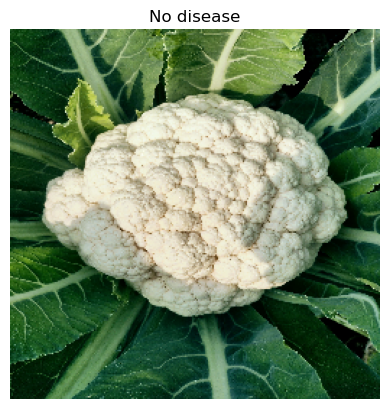

In [6]:
# Printing an image

for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.axis('off')
    plt.title(class_names[label_batch[0]])

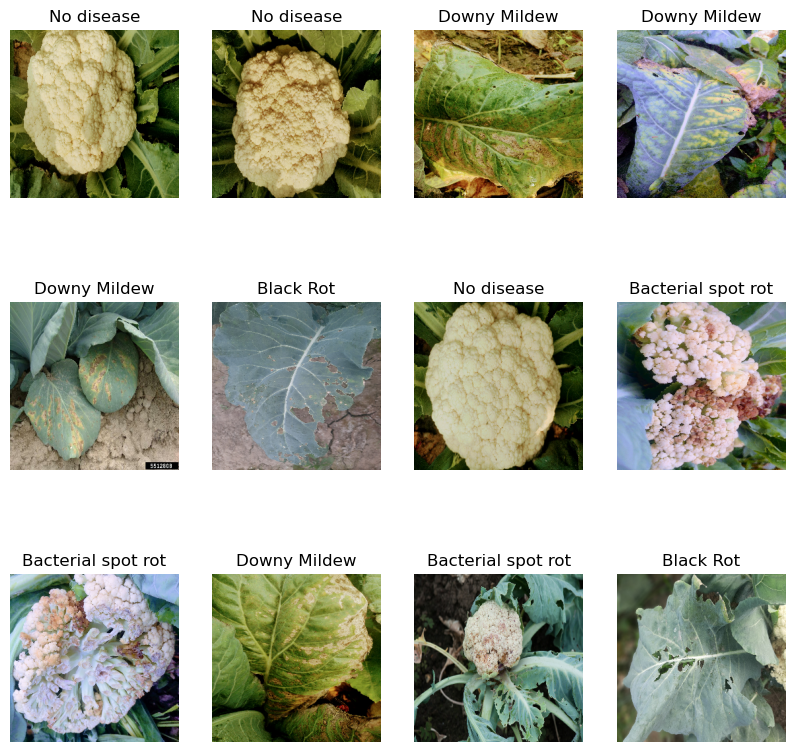

In [7]:
# Printing an image

plt.figure(figsize=(10,10))# setting the general display size on the screen
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        # subplot should be used, when displaying multiple images
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(class_names[label_batch[i]])

# Splitting the dataset into 'Train' and 'Test'

In [8]:


def get_dataset_partitions_tf(ds, train_split=.8, test_split=.1, val_split=.1,shuffle=True, shuffle_size=200):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
        
    train_ds=ds.take(int(ds_size*train_split))
    test_ds_1=ds.skip(int(ds_size*train_split))
    val_ds=test_ds_1.take(int(val_split*ds_size))
    test_ds=test_ds_1.skip(int(val_split*ds_size))
    
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [10]:
len(train_ds)

16

In [11]:
len(val_ds)

2

In [12]:
len(test_ds)

3

In [13]:
# Loading the image data into memory, rather than having to fetch from ssd every time => improves performance of model

train_ds=train_ds.cache().shuffle(200).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(200).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(200).prefetch(buffer_size=tf.data.AUTOTUNE)

# the prefetch will help in reducing the idel time of CPU(by fetchiung the data from ssd),
# while the GPU is working on the previous batch of data, fetched by the CPU

# Data Augmentation:

In [14]:
from tensorflow.keras import models, layers

In [15]:
# if necessary, watch codebasics 'prefetch & cache', 'data augmentation' videos..

resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(img_size,img_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [16]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(.2)
])

# Model Building:


In [17]:
input_shape=(bat_size,img_size,img_size,3)
n_classes=4

model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
    
])

# The above values of 32,64 etc... and the number of convolutional layers must be found by trial and error..

model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [19]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [20]:
# training the model and recording its history..

history = model.fit(
    train_ds,
    epochs=36,
    batch_size=bat_size,
    verbose=1,
    validation_data=val_ds)

Epoch 1/36


2023-10-05 22:34:35.367252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-05 22:34:35.553972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:34:35.683073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/16 [>.............................] - ETA: 3:17 - loss: 1.3706 - accuracy: 0.3438

2023-10-05 22:34:48.035949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:34:48.036391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/16 [==>...........................] - ETA: 4s - loss: 1.3736 - accuracy: 0.2656  

2023-10-05 22:34:48.321169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:34:48.321776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/16 [====>.........................] - ETA: 3s - loss: 1.3316 - accuracy: 0.2500

2023-10-05 22:34:48.555092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:34:48.555894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/16 [======>.......................] - ETA: 3s - loss: 1.3698 - accuracy: 0.2656

2023-10-05 22:34:48.789189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:34:48.789797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/16 [========>.....................] - ETA: 2s - loss: 1.4109 - accuracy: 0.2688

2023-10-05 22:34:49.022397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:34:49.023189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/16 [==========>...................] - ETA: 2s - loss: 1.4250 - accuracy: 0.2656

2023-10-05 22:34:49.262278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:34:49.262533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/16 [============>.................] - ETA: 2s - loss: 1.4126 - accuracy: 0.2723

2023-10-05 22:34:49.488887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:34:49.489502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/16 [==============>...............] - ETA: 1s - loss: 1.4130 - accuracy: 0.2656

2023-10-05 22:34:49.725021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:34:49.725668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/16 [===============>..............] - ETA: 1s - loss: 1.4098 - accuracy: 0.2604

2023-10-05 22:34:49.958909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:34:49.959255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/16 [=================>............] - ETA: 1s - loss: 1.4046 - accuracy: 0.2594

2023-10-05 22:34:50.195599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:34:50.196222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/16 [===================>..........] - ETA: 2s - loss: 1.4030 - accuracy: 0.2619

2023-10-05 22:34:53.171261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:34:53.171563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/16 [=====================>........] - ETA: 1s - loss: 1.4008 - accuracy: 0.2690

2023-10-05 22:34:53.426671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:34:53.427068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/16 [=======================>......] - ETA: 1s - loss: 1.3974 - accuracy: 0.2750

2023-10-05 22:34:53.652849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:34:53.653501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/16 [=========================>....] - ETA: 0s - loss: 1.3935 - accuracy: 0.2708

2023-10-05 22:34:53.902909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:34:53.903304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/16 [===========================>..] - ETA: 0s - loss: 1.3921 - accuracy: 0.2716

2023-10-05 22:34:54.146384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:34:54.146768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - ETA: 0s - loss: 1.3903 - accuracy: 0.2702

2023-10-05 22:34:54.542890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 30s 1s/step - loss: 1.3903 - accuracy: 0.2702 - val_loss: 1.3705 - val_accuracy: 0.2708
Epoch 2/36


2023-10-05 22:35:05.170198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:05.170460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/16 [>.............................] - ETA: 5s - loss: 1.4010 - accuracy: 0.1562

2023-10-05 22:35:05.557570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:05.558502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/16 [==>...........................] - ETA: 3s - loss: 1.3603 - accuracy: 0.2344

2023-10-05 22:35:05.813068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:05.813761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/16 [====>.........................] - ETA: 3s - loss: 1.3563 - accuracy: 0.2917

2023-10-05 22:35:06.053403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:06.053724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/16 [======>.......................] - ETA: 2s - loss: 1.3582 - accuracy: 0.2812

2023-10-05 22:35:06.295212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:06.295527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/16 [========>.....................] - ETA: 2s - loss: 1.3766 - accuracy: 0.2688

2023-10-05 22:35:06.531209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:06.531572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/16 [==========>...................] - ETA: 2s - loss: 1.3773 - accuracy: 0.2865

2023-10-05 22:35:06.764856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:06.765569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/16 [============>.................] - ETA: 2s - loss: 1.3695 - accuracy: 0.2768

2023-10-05 22:35:07.011640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:07.012195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/16 [==============>...............] - ETA: 1s - loss: 1.3626 - accuracy: 0.2852

2023-10-05 22:35:07.249206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:07.249639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/16 [===============>..............] - ETA: 1s - loss: 1.3568 - accuracy: 0.2778

2023-10-05 22:35:07.484248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:07.484566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/16 [=================>............] - ETA: 1s - loss: 1.3584 - accuracy: 0.2875

2023-10-05 22:35:07.718183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:07.719077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/16 [===================>..........] - ETA: 1s - loss: 1.3593 - accuracy: 0.2898

2023-10-05 22:35:07.963220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:07.963539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/16 [=====================>........] - ETA: 0s - loss: 1.3580 - accuracy: 0.2908

2023-10-05 22:35:08.174253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:08.174567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/16 [=======================>......] - ETA: 0s - loss: 1.3589 - accuracy: 0.2900

2023-10-05 22:35:08.413282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:08.413560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/16 [=========================>....] - ETA: 0s - loss: 1.3594 - accuracy: 0.2894

2023-10-05 22:35:08.649480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:08.649720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/16 [===========================>..] - ETA: 0s - loss: 1.3548 - accuracy: 0.2888

2023-10-05 22:35:08.886540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:08.886950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - 4s 249ms/step - loss: 1.3503 - accuracy: 0.2923 - val_loss: 1.3598 - val_accuracy: 0.2708
Epoch 3/36


2023-10-05 22:35:09.285386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:09.285765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/16 [>.............................] - ETA: 3s - loss: 1.2834 - accuracy: 0.3125

2023-10-05 22:35:09.517305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:09.518065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/16 [==>...........................] - ETA: 3s - loss: 1.3229 - accuracy: 0.2812

2023-10-05 22:35:09.750474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:09.751707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/16 [====>.........................] - ETA: 3s - loss: 1.2975 - accuracy: 0.2604

2023-10-05 22:35:09.999195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:09.999445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/16 [======>.......................] - ETA: 2s - loss: 1.3003 - accuracy: 0.2969

2023-10-05 22:35:10.232921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:10.233642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/16 [==========>...................] - ETA: 2s - loss: 1.2928 - accuracy: 0.2955

2023-10-05 22:35:10.470773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:10.471092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:10.622440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:10.622625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/16 [============>.................] - ETA: 2s - loss: 1.3031 - accuracy: 0.2933

2023-10-05 22:35:10.881133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:10.881916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/16 [==============>...............] - ETA: 1s - loss: 1.3086 - accuracy: 0.3083

2023-10-05 22:35:11.126215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:11.126890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/16 [===============>..............] - ETA: 1s - loss: 1.3075 - accuracy: 0.3051

2023-10-05 22:35:11.365995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:11.366668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/16 [=================>............] - ETA: 1s - loss: 1.3065 - accuracy: 0.3059

2023-10-05 22:35:11.603701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:11.603861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/16 [===================>..........] - ETA: 1s - loss: 1.3084 - accuracy: 0.3095

2023-10-05 22:35:11.838499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:11.839191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/16 [=====================>........] - ETA: 0s - loss: 1.2986 - accuracy: 0.3179

2023-10-05 22:35:12.078536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:12.079317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/16 [=======================>......] - ETA: 0s - loss: 1.3075 - accuracy: 0.3150

2023-10-05 22:35:12.317222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:12.317992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/16 [=========================>....] - ETA: 0s - loss: 1.3334 - accuracy: 0.3079

2023-10-05 22:35:12.553460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:12.553926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/16 [===========================>..] - ETA: 0s - loss: 1.3348 - accuracy: 0.3168

2023-10-05 22:35:12.789020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:12.789392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - 4s 244ms/step - loss: 1.3307 - accuracy: 0.3165 - val_loss: 1.3303 - val_accuracy: 0.3958
Epoch 4/36


2023-10-05 22:35:13.185317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:13.185530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/16 [>.............................] - ETA: 3s - loss: 1.3402 - accuracy: 0.2812

2023-10-05 22:35:13.412529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:13.413151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/16 [==>...........................] - ETA: 3s - loss: 1.3655 - accuracy: 0.3438

2023-10-05 22:35:13.653270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:13.653640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/16 [====>.........................] - ETA: 3s - loss: 1.3565 - accuracy: 0.3646

2023-10-05 22:35:13.883368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:13.884195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/16 [======>.......................] - ETA: 2s - loss: 1.3602 - accuracy: 0.3281

2023-10-05 22:35:14.111827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:14.112485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/16 [========>.....................] - ETA: 2s - loss: 1.3696 - accuracy: 0.3375

2023-10-05 22:35:14.339359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:14.339986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/16 [==========>...................] - ETA: 2s - loss: 1.3636 - accuracy: 0.3281

2023-10-05 22:35:14.577299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:14.578010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/16 [============>.................] - ETA: 2s - loss: 1.3773 - accuracy: 0.3080

2023-10-05 22:35:14.810886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:14.811206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/16 [==============>...............] - ETA: 1s - loss: 1.3716 - accuracy: 0.3242

2023-10-05 22:35:15.041951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:15.042541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/16 [===============>..............] - ETA: 1s - loss: 1.3711 - accuracy: 0.3229

2023-10-05 22:35:15.272464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:15.273086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/16 [=================>............] - ETA: 1s - loss: 1.3729 - accuracy: 0.3187

2023-10-05 22:35:15.503500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:15.503555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/16 [=====================>........] - ETA: 0s - loss: 1.3620 - accuracy: 0.3261

2023-10-05 22:35:15.729673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:15.730615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:15.890910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:15.891214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/16 [=======================>......] - ETA: 0s - loss: 1.3666 - accuracy: 0.3200

2023-10-05 22:35:16.130543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:16.130820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/16 [=========================>....] - ETA: 0s - loss: 1.3584 - accuracy: 0.3356

2023-10-05 22:35:16.363946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:16.364389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/16 [===========================>..] - ETA: 0s - loss: 1.3534 - accuracy: 0.3341

2023-10-05 22:35:16.597691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:16.598312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - 4s 238ms/step - loss: 1.3456 - accuracy: 0.3367 - val_loss: 1.2654 - val_accuracy: 0.4167
Epoch 5/36


2023-10-05 22:35:16.986276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:16.986461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/16 [>.............................] - ETA: 3s - loss: 1.1778 - accuracy: 0.5000

2023-10-05 22:35:17.208517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:17.209588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/16 [==>...........................] - ETA: 3s - loss: 1.1753 - accuracy: 0.5312

2023-10-05 22:35:17.439160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:17.439534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/16 [====>.........................] - ETA: 3s - loss: 1.1050 - accuracy: 0.5625

2023-10-05 22:35:17.679294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:17.679894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/16 [======>.......................] - ETA: 2s - loss: 1.1824 - accuracy: 0.5312

2023-10-05 22:35:17.908828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:17.909551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/16 [========>.....................] - ETA: 2s - loss: 1.2410 - accuracy: 0.5125

2023-10-05 22:35:18.139480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:18.140255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/16 [==========>...................] - ETA: 2s - loss: 1.2931 - accuracy: 0.5208

2023-10-05 22:35:18.370035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:18.370057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/16 [============>.................] - ETA: 2s - loss: 1.2556 - accuracy: 0.5134

2023-10-05 22:35:18.603272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:18.603262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/16 [==============>...............] - ETA: 1s - loss: 1.2568 - accuracy: 0.5195

2023-10-05 22:35:18.832337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:18.832925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/16 [===============>..............] - ETA: 1s - loss: 1.2490 - accuracy: 0.5069

2023-10-05 22:35:19.065230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:19.065589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/16 [=================>............] - ETA: 1s - loss: 1.2776 - accuracy: 0.5094

2023-10-05 22:35:19.297846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:19.298296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/16 [===================>..........] - ETA: 1s - loss: 1.3644 - accuracy: 0.4915

2023-10-05 22:35:19.532309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:19.533070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/16 [=======================>......] - ETA: 0s - loss: 1.3534 - accuracy: 0.4925

2023-10-05 22:35:19.761598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:19.762373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:19.916745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:19.916861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/16 [=========================>....] - ETA: 0s - loss: 1.3919 - accuracy: 0.4838

2023-10-05 22:35:20.142584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:20.142911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/16 [===========================>..] - ETA: 0s - loss: 1.4357 - accuracy: 0.4634

2023-10-05 22:35:20.379017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:20.379702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - 4s 237ms/step - loss: 1.4155 - accuracy: 0.4677 - val_loss: 1.1621 - val_accuracy: 0.4583
Epoch 6/36


2023-10-05 22:35:20.762102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:20.762311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/16 [>.............................] - ETA: 3s - loss: 1.1395 - accuracy: 0.4375

2023-10-05 22:35:20.990041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:20.990766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/16 [==>...........................] - ETA: 3s - loss: 1.1478 - accuracy: 0.4844

2023-10-05 22:35:21.226566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:21.227222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/16 [====>.........................] - ETA: 3s - loss: 1.1690 - accuracy: 0.4271

2023-10-05 22:35:21.461282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:21.461939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/16 [======>.......................] - ETA: 2s - loss: 1.1885 - accuracy: 0.4141

2023-10-05 22:35:21.692151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:21.692756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/16 [========>.....................] - ETA: 2s - loss: 1.1818 - accuracy: 0.3938

2023-10-05 22:35:21.933767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:21.933771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/16 [==========>...................] - ETA: 2s - loss: 1.1893 - accuracy: 0.3958

2023-10-05 22:35:22.162327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:22.162938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/16 [============>.................] - ETA: 2s - loss: 1.1722 - accuracy: 0.4152

2023-10-05 22:35:22.394268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:22.395064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/16 [==============>...............] - ETA: 1s - loss: 1.1777 - accuracy: 0.4023

2023-10-05 22:35:22.626813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:22.627502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/16 [===============>..............] - ETA: 1s - loss: 1.1801 - accuracy: 0.3889

2023-10-05 22:35:22.860883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:22.861537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/16 [=================>............] - ETA: 1s - loss: 1.1845 - accuracy: 0.3844

2023-10-05 22:35:23.095637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:23.096320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/16 [===================>..........] - ETA: 1s - loss: 1.1815 - accuracy: 0.3920

2023-10-05 22:35:23.329756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:23.330315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/16 [=====================>........] - ETA: 0s - loss: 1.1789 - accuracy: 0.4036

2023-10-05 22:35:23.562290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:23.562611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/16 [=======================>......] - ETA: 0s - loss: 1.1772 - accuracy: 0.4207

2023-10-05 22:35:23.794212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:23.794600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/16 [=========================>....] - ETA: 0s - loss: 1.1737 - accuracy: 0.4286

2023-10-05 22:35:24.026904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:24.027593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - ETA: 0s - loss: 1.1739 - accuracy: 0.4254

2023-10-05 22:35:24.257554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:24.258255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - 4s 239ms/step - loss: 1.1739 - accuracy: 0.4254 - val_loss: 1.1966 - val_accuracy: 0.3542
Epoch 7/36


2023-10-05 22:35:24.576240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:24.576437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/16 [>.............................] - ETA: 3s - loss: 1.1826 - accuracy: 0.3438

2023-10-05 22:35:24.802644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:24.803433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/16 [==>...........................] - ETA: 3s - loss: 1.2085 - accuracy: 0.3750

2023-10-05 22:35:25.039779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:25.040492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/16 [====>.........................] - ETA: 3s - loss: 1.1604 - accuracy: 0.4167

2023-10-05 22:35:25.271755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:25.272367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/16 [======>.......................] - ETA: 2s - loss: 1.1618 - accuracy: 0.3984

2023-10-05 22:35:25.509968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:25.510400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/16 [========>.....................] - ETA: 2s - loss: 1.1547 - accuracy: 0.4250

2023-10-05 22:35:25.748130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:25.748406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/16 [==========>...................] - ETA: 2s - loss: 1.1496 - accuracy: 0.4219

2023-10-05 22:35:25.984288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:25.985063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/16 [============>.................] - ETA: 2s - loss: 1.1368 - accuracy: 0.4375

2023-10-05 22:35:26.222445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:26.223250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/16 [===============>..............] - ETA: 1s - loss: 1.1476 - accuracy: 0.4522

2023-10-05 22:35:26.460399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:26.461251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:26.604299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:26.604837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/16 [=================>............] - ETA: 1s - loss: 1.1610 - accuracy: 0.4441

2023-10-05 22:35:26.826419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:26.827069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/16 [===================>..........] - ETA: 1s - loss: 1.1827 - accuracy: 0.4464

2023-10-05 22:35:27.062385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:27.063201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/16 [=====================>........] - ETA: 0s - loss: 1.1765 - accuracy: 0.4565

2023-10-05 22:35:27.300117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:27.300818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/16 [=======================>......] - ETA: 0s - loss: 1.1873 - accuracy: 0.4650

2023-10-05 22:35:27.539015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:27.539733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/16 [=========================>....] - ETA: 0s - loss: 1.1676 - accuracy: 0.4792

2023-10-05 22:35:27.773145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:27.773274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/16 [===========================>..] - ETA: 0s - loss: 1.1888 - accuracy: 0.4806

2023-10-05 22:35:28.008980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:28.009599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - 4s 240ms/step - loss: 1.1768 - accuracy: 0.4899 - val_loss: 1.5066 - val_accuracy: 0.5208
Epoch 8/36


2023-10-05 22:35:28.398521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:28.398521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/16 [>.............................] - ETA: 3s - loss: 1.1706 - accuracy: 0.4688

2023-10-05 22:35:28.613220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:28.614262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/16 [==>...........................] - ETA: 3s - loss: 1.2452 - accuracy: 0.5312

2023-10-05 22:35:28.843823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:28.843839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/16 [====>.........................] - ETA: 2s - loss: 1.2030 - accuracy: 0.5417

2023-10-05 22:35:29.075224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:29.075924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/16 [======>.......................] - ETA: 2s - loss: 1.2994 - accuracy: 0.5234

2023-10-05 22:35:29.303035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:29.303205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/16 [========>.....................] - ETA: 2s - loss: 1.4297 - accuracy: 0.5125

2023-10-05 22:35:29.529891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:29.530051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/16 [==========>...................] - ETA: 2s - loss: 1.5466 - accuracy: 0.5104

2023-10-05 22:35:29.761397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:29.762564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/16 [============>.................] - ETA: 2s - loss: 1.6555 - accuracy: 0.4955

2023-10-05 22:35:29.992079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:29.992836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/16 [==============>...............] - ETA: 1s - loss: 1.6544 - accuracy: 0.5078

2023-10-05 22:35:30.222491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:30.223033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/16 [===============>..............] - ETA: 1s - loss: 1.7139 - accuracy: 0.5035

2023-10-05 22:35:30.450817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:30.451323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/16 [=================>............] - ETA: 1s - loss: 1.7000 - accuracy: 0.5063

2023-10-05 22:35:30.680350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:30.681489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/16 [===================>..........] - ETA: 1s - loss: 1.6727 - accuracy: 0.4972

2023-10-05 22:35:30.910733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:30.911603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/16 [=====================>........] - ETA: 0s - loss: 1.6148 - accuracy: 0.5026

2023-10-05 22:35:31.142540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:31.142580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/16 [=======================>......] - ETA: 0s - loss: 1.5727 - accuracy: 0.5072

2023-10-05 22:35:31.372039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:31.372716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/16 [=========================>....] - ETA: 0s - loss: 1.5744 - accuracy: 0.5000

2023-10-05 22:35:31.602146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:31.602266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - ETA: 0s - loss: 1.6152 - accuracy: 0.4859

2023-10-05 22:35:31.830833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:31.831868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - 4s 233ms/step - loss: 1.6152 - accuracy: 0.4859 - val_loss: 1.2357 - val_accuracy: 0.5208
Epoch 9/36


2023-10-05 22:35:32.112663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:32.113177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/16 [==>...........................] - ETA: 1s - loss: 1.3114 - accuracy: 0.3958

2023-10-05 22:35:32.330240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:32.331107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:32.468765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:32.469201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/16 [====>.........................] - ETA: 2s - loss: 1.1326 - accuracy: 0.4875

2023-10-05 22:35:32.688509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:32.688852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/16 [======>.......................] - ETA: 2s - loss: 1.0661 - accuracy: 0.5268

2023-10-05 22:35:32.917345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:32.917875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/16 [========>.....................] - ETA: 2s - loss: 1.0281 - accuracy: 0.5278

2023-10-05 22:35:33.147226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:33.148380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/16 [==========>...................] - ETA: 2s - loss: 1.0489 - accuracy: 0.4943

2023-10-05 22:35:33.378888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:33.379271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/16 [============>.................] - ETA: 1s - loss: 1.0560 - accuracy: 0.4712

2023-10-05 22:35:33.608622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:33.609101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/16 [==============>...............] - ETA: 1s - loss: 1.0584 - accuracy: 0.4667

2023-10-05 22:35:33.840039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:33.840785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/16 [===============>..............] - ETA: 1s - loss: 1.0799 - accuracy: 0.4559

2023-10-05 22:35:34.071577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:34.071982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/16 [=================>............] - ETA: 1s - loss: 1.0998 - accuracy: 0.4342

2023-10-05 22:35:34.304309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:34.304833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/16 [===================>..........] - ETA: 1s - loss: 1.1047 - accuracy: 0.4315

2023-10-05 22:35:34.534908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:34.536482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/16 [=====================>........] - ETA: 0s - loss: 1.1029 - accuracy: 0.4402

2023-10-05 22:35:34.765873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:34.765876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/16 [=======================>......] - ETA: 0s - loss: 1.1087 - accuracy: 0.4350

2023-10-05 22:35:34.996071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:34.997142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/16 [=========================>....] - ETA: 0s - loss: 1.1119 - accuracy: 0.4375

2023-10-05 22:35:35.228764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:35.228802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/16 [===========================>..] - ETA: 0s - loss: 1.1174 - accuracy: 0.4267

2023-10-05 22:35:35.460192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:35.461136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - 4s 234ms/step - loss: 1.1234 - accuracy: 0.4173 - val_loss: 1.1769 - val_accuracy: 0.4167
Epoch 10/36


2023-10-05 22:35:35.841325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:35.841843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/16 [>.............................] - ETA: 3s - loss: 1.1758 - accuracy: 0.4375

2023-10-05 22:35:36.061417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:36.061415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/16 [==>...........................] - ETA: 3s - loss: 1.1661 - accuracy: 0.3906

2023-10-05 22:35:36.289493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:36.290226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/16 [====>.........................] - ETA: 2s - loss: 1.1392 - accuracy: 0.4062

2023-10-05 22:35:36.518146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:36.518825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/16 [======>.......................] - ETA: 2s - loss: 1.1474 - accuracy: 0.4141

2023-10-05 22:35:36.750386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:36.750410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/16 [========>.....................] - ETA: 2s - loss: 1.1338 - accuracy: 0.4375

2023-10-05 22:35:36.983514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:36.983786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/16 [==========>...................] - ETA: 2s - loss: 1.1289 - accuracy: 0.4427

2023-10-05 22:35:37.213288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:37.213642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/16 [============>.................] - ETA: 2s - loss: 1.1300 - accuracy: 0.4375

2023-10-05 22:35:37.443717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:37.444434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/16 [==============>...............] - ETA: 1s - loss: 1.1160 - accuracy: 0.4492

2023-10-05 22:35:37.678651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:37.679883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/16 [=================>............] - ETA: 1s - loss: 1.1165 - accuracy: 0.4441

2023-10-05 22:35:37.913050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:37.914291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:38.057626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:38.058270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/16 [===================>..........] - ETA: 1s - loss: 1.1100 - accuracy: 0.4494

2023-10-05 22:35:38.276599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:38.277552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/16 [=====================>........] - ETA: 0s - loss: 1.1224 - accuracy: 0.4484

2023-10-05 22:35:38.508890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:38.509905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/16 [=======================>......] - ETA: 0s - loss: 1.1278 - accuracy: 0.4450

2023-10-05 22:35:38.741290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:38.741770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/16 [=========================>....] - ETA: 0s - loss: 1.1274 - accuracy: 0.4537

2023-10-05 22:35:38.971571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:38.971995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/16 [===========================>..] - ETA: 0s - loss: 1.1246 - accuracy: 0.4634

2023-10-05 22:35:39.204187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:39.204227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - 4s 235ms/step - loss: 1.1241 - accuracy: 0.4718 - val_loss: 1.1252 - val_accuracy: 0.4583
Epoch 11/36


2023-10-05 22:35:39.584685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:39.585068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/16 [>.............................] - ETA: 3s - loss: 1.0934 - accuracy: 0.5000

2023-10-05 22:35:39.804679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:39.805843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/16 [==>...........................] - ETA: 3s - loss: 1.0666 - accuracy: 0.4844

2023-10-05 22:35:40.033155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:40.034171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/16 [====>.........................] - ETA: 2s - loss: 1.0831 - accuracy: 0.4792

2023-10-05 22:35:40.263342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:40.263753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/16 [======>.......................] - ETA: 2s - loss: 1.1091 - accuracy: 0.4688

2023-10-05 22:35:40.494498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:40.495125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/16 [========>.....................] - ETA: 2s - loss: 1.1203 - accuracy: 0.4688

2023-10-05 22:35:40.725458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:40.726076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/16 [==========>...................] - ETA: 2s - loss: 1.0820 - accuracy: 0.4896

2023-10-05 22:35:40.955924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:40.956786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/16 [============>.................] - ETA: 2s - loss: 1.0697 - accuracy: 0.4955

2023-10-05 22:35:41.187719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:41.188401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/16 [==============>...............] - ETA: 1s - loss: 1.0611 - accuracy: 0.5195

2023-10-05 22:35:41.417600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:41.418556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/16 [===============>..............] - ETA: 1s - loss: 1.0591 - accuracy: 0.5243

2023-10-05 22:35:41.650302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:41.650776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/16 [===================>..........] - ETA: 1s - loss: 1.0515 - accuracy: 0.5119

2023-10-05 22:35:41.879456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:41.880438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:42.025802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:42.025979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/16 [=====================>........] - ETA: 0s - loss: 1.0407 - accuracy: 0.5190

2023-10-05 22:35:42.242779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:42.243404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/16 [=======================>......] - ETA: 0s - loss: 1.0573 - accuracy: 0.5150

2023-10-05 22:35:42.474160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:42.474198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/16 [=========================>....] - ETA: 0s - loss: 1.0527 - accuracy: 0.5139

2023-10-05 22:35:42.704595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:42.705289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/16 [===========================>..] - ETA: 0s - loss: 1.0659 - accuracy: 0.5129

2023-10-05 22:35:42.935200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:42.936430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - 4s 234ms/step - loss: 1.0877 - accuracy: 0.5040 - val_loss: 1.3419 - val_accuracy: 0.4583
Epoch 12/36


2023-10-05 22:35:43.310301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:43.310792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/16 [>.............................] - ETA: 3s - loss: 1.3026 - accuracy: 0.4688

2023-10-05 22:35:43.529040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:43.529539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/16 [==>...........................] - ETA: 3s - loss: 1.1990 - accuracy: 0.4844

2023-10-05 22:35:43.759791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:43.759872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/16 [====>.........................] - ETA: 3s - loss: 1.1315 - accuracy: 0.5208

2023-10-05 22:35:43.991880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:43.992564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/16 [========>.....................] - ETA: 2s - loss: 1.0374 - accuracy: 0.5625

2023-10-05 22:35:44.222138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:44.223097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:44.365002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:44.365602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/16 [==========>...................] - ETA: 2s - loss: 1.0367 - accuracy: 0.5568

2023-10-05 22:35:44.584874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:44.585164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/16 [============>.................] - ETA: 1s - loss: 1.0424 - accuracy: 0.5625

2023-10-05 22:35:44.814980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:44.815577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/16 [==============>...............] - ETA: 1s - loss: 1.0611 - accuracy: 0.5458

2023-10-05 22:35:45.044285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:45.044956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/16 [===============>..............] - ETA: 1s - loss: 1.0372 - accuracy: 0.5478

2023-10-05 22:35:45.273435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:45.274187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/16 [=================>............] - ETA: 1s - loss: 1.0143 - accuracy: 0.5428

2023-10-05 22:35:45.505321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:45.505695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/16 [===================>..........] - ETA: 1s - loss: 1.0013 - accuracy: 0.5387

2023-10-05 22:35:45.736944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:45.737046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/16 [=====================>........] - ETA: 0s - loss: 0.9955 - accuracy: 0.5462

2023-10-05 22:35:45.967983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:45.968290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/16 [=======================>......] - ETA: 0s - loss: 0.9980 - accuracy: 0.5375

2023-10-05 22:35:46.196196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:46.197027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/16 [=========================>....] - ETA: 0s - loss: 0.9994 - accuracy: 0.5394

2023-10-05 22:35:46.429851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:46.431028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/16 [===========================>..] - ETA: 0s - loss: 1.0011 - accuracy: 0.5323

2023-10-05 22:35:46.659765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:46.660253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - 4s 234ms/step - loss: 0.9994 - accuracy: 0.5302 - val_loss: 0.9425 - val_accuracy: 0.5000
Epoch 13/36


2023-10-05 22:35:47.037950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:47.038530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/16 [>.............................] - ETA: 3s - loss: 0.9634 - accuracy: 0.5312

2023-10-05 22:35:47.256900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:47.257532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/16 [==>...........................] - ETA: 3s - loss: 1.0144 - accuracy: 0.4688

2023-10-05 22:35:47.485682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:47.485777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/16 [====>.........................] - ETA: 2s - loss: 0.9890 - accuracy: 0.5208

2023-10-05 22:35:47.710998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:47.712110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/16 [======>.......................] - ETA: 2s - loss: 0.9469 - accuracy: 0.5312

2023-10-05 22:35:47.944367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:47.944497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/16 [========>.....................] - ETA: 2s - loss: 0.9048 - accuracy: 0.5562

2023-10-05 22:35:48.176511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:48.177114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/16 [==========>...................] - ETA: 2s - loss: 0.8986 - accuracy: 0.5573

2023-10-05 22:35:48.407395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:48.407565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/16 [============>.................] - ETA: 2s - loss: 0.9037 - accuracy: 0.5446

2023-10-05 22:35:48.638991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:48.639124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/16 [==============>...............] - ETA: 1s - loss: 0.8911 - accuracy: 0.5547

2023-10-05 22:35:48.870726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:48.870730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/16 [=================>............] - ETA: 1s - loss: 0.8865 - accuracy: 0.5526

2023-10-05 22:35:49.098860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:49.099983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:49.243835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:49.244069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/16 [===================>..........] - ETA: 1s - loss: 0.8933 - accuracy: 0.5476

2023-10-05 22:35:49.468365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:49.468981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/16 [=====================>........] - ETA: 0s - loss: 0.9030 - accuracy: 0.5435

2023-10-05 22:35:49.699009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:49.699596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/16 [=======================>......] - ETA: 0s - loss: 0.9442 - accuracy: 0.5325

2023-10-05 22:35:49.928520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:49.929464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/16 [=========================>....] - ETA: 0s - loss: 0.9699 - accuracy: 0.5255

2023-10-05 22:35:50.160181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:50.160510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/16 [===========================>..] - ETA: 0s - loss: 0.9834 - accuracy: 0.5194

2023-10-05 22:35:50.392548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:50.393511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - 4s 234ms/step - loss: 1.0067 - accuracy: 0.5141 - val_loss: 1.2484 - val_accuracy: 0.4583
Epoch 14/36


2023-10-05 22:35:50.772494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:50.773538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/16 [>.............................] - ETA: 3s - loss: 1.2077 - accuracy: 0.5000

2023-10-05 22:35:50.992699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:50.993041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/16 [==>...........................] - ETA: 3s - loss: 1.1300 - accuracy: 0.5469

2023-10-05 22:35:51.224756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:51.225385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/16 [====>.........................] - ETA: 3s - loss: 1.1488 - accuracy: 0.5208

2023-10-05 22:35:51.459342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:51.459725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/16 [======>.......................] - ETA: 2s - loss: 1.1814 - accuracy: 0.5000

2023-10-05 22:35:51.689272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:51.690203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/16 [========>.....................] - ETA: 2s - loss: 1.1325 - accuracy: 0.5125

2023-10-05 22:35:51.920397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:51.920603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/16 [==========>...................] - ETA: 2s - loss: 1.0910 - accuracy: 0.5365

2023-10-05 22:35:52.147173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:52.147532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/16 [============>.................] - ETA: 2s - loss: 1.1037 - accuracy: 0.5223

2023-10-05 22:35:52.380374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:52.381192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/16 [==============>...............] - ETA: 1s - loss: 1.0920 - accuracy: 0.5234

2023-10-05 22:35:52.613100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:52.613214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/16 [===============>..............] - ETA: 1s - loss: 1.1380 - accuracy: 0.4965

2023-10-05 22:35:52.843492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:52.844019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/16 [=================>............] - ETA: 1s - loss: 1.1448 - accuracy: 0.4844

2023-10-05 22:35:53.072279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:53.073101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/16 [===================>..........] - ETA: 1s - loss: 1.1298 - accuracy: 0.4886

2023-10-05 22:35:53.304030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:53.304624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/16 [=====================>........] - ETA: 0s - loss: 1.1130 - accuracy: 0.5026

2023-10-05 22:35:53.538995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:53.539566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/16 [=========================>....] - ETA: 0s - loss: 1.0853 - accuracy: 0.5162

2023-10-05 22:35:53.770743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:53.771271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:53.914558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:53.915046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/16 [===========================>..] - ETA: 0s - loss: 1.0776 - accuracy: 0.5216

2023-10-05 22:35:54.134325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:54.135342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - 4s 235ms/step - loss: 1.0567 - accuracy: 0.5282 - val_loss: 0.9371 - val_accuracy: 0.5208
Epoch 15/36


2023-10-05 22:35:54.514835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:54.514865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/16 [>.............................] - ETA: 3s - loss: 1.0486 - accuracy: 0.5000

2023-10-05 22:35:54.735691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:54.736184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/16 [==>...........................] - ETA: 3s - loss: 0.9706 - accuracy: 0.5781

2023-10-05 22:35:54.965514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:54.966544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/16 [====>.........................] - ETA: 3s - loss: 1.0166 - accuracy: 0.5833

2023-10-05 22:35:55.197004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:55.197922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/16 [======>.......................] - ETA: 2s - loss: 1.0401 - accuracy: 0.5547

2023-10-05 22:35:55.427489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:55.428519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/16 [========>.....................] - ETA: 2s - loss: 1.0381 - accuracy: 0.5625

2023-10-05 22:35:55.662757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:55.663347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/16 [==========>...................] - ETA: 2s - loss: 1.0514 - accuracy: 0.5469

2023-10-05 22:35:55.894181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:55.895167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/16 [==============>...............] - ETA: 1s - loss: 1.1005 - accuracy: 0.5250

2023-10-05 22:35:56.122926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:56.124024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:56.270304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:56.270315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/16 [===============>..............] - ETA: 1s - loss: 1.1375 - accuracy: 0.5257

2023-10-05 22:35:56.490814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:56.491493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/16 [=================>............] - ETA: 1s - loss: 1.1432 - accuracy: 0.5230

2023-10-05 22:35:56.717615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:56.718475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/16 [===================>..........] - ETA: 1s - loss: 1.1332 - accuracy: 0.5208

2023-10-05 22:35:56.943489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:56.944118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/16 [=====================>........] - ETA: 0s - loss: 1.1293 - accuracy: 0.5190

2023-10-05 22:35:57.169497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:57.170480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/16 [=======================>......] - ETA: 0s - loss: 1.1574 - accuracy: 0.5150

2023-10-05 22:35:57.396002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:57.396951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/16 [=========================>....] - ETA: 0s - loss: 1.1711 - accuracy: 0.5162

2023-10-05 22:35:57.629984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:57.630488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/16 [===========================>..] - ETA: 0s - loss: 1.1710 - accuracy: 0.5151

2023-10-05 22:35:57.857977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:57.859694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - 4s 234ms/step - loss: 1.1524 - accuracy: 0.5202 - val_loss: 1.0569 - val_accuracy: 0.5625
Epoch 16/36


2023-10-05 22:35:58.238078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:58.238620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/16 [>.............................] - ETA: 3s - loss: 1.2905 - accuracy: 0.5000

2023-10-05 22:35:58.458228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:58.458274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/16 [==>...........................] - ETA: 3s - loss: 1.1317 - accuracy: 0.5625

2023-10-05 22:35:58.691113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:58.691596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/16 [====>.........................] - ETA: 3s - loss: 1.1284 - accuracy: 0.5521

2023-10-05 22:35:58.920482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:58.921300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/16 [======>.......................] - ETA: 2s - loss: 1.0919 - accuracy: 0.5625

2023-10-05 22:35:59.148434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:59.148857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/16 [========>.....................] - ETA: 2s - loss: 1.0825 - accuracy: 0.5625

2023-10-05 22:35:59.383194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:59.384194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/16 [==========>...................] - ETA: 2s - loss: 1.0749 - accuracy: 0.5521

2023-10-05 22:35:59.617776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:59.618275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/16 [==============>...............] - ETA: 1s - loss: 1.0684 - accuracy: 0.5625

2023-10-05 22:35:59.848307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:59.849190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:59.993354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:35:59.994028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/16 [===============>..............] - ETA: 1s - loss: 1.0766 - accuracy: 0.5551

2023-10-05 22:36:00.210764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:00.211308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/16 [=================>............] - ETA: 1s - loss: 1.0847 - accuracy: 0.5592

2023-10-05 22:36:00.446079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:00.446279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/16 [===================>..........] - ETA: 1s - loss: 1.0848 - accuracy: 0.5536

2023-10-05 22:36:00.674772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:00.675783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/16 [=====================>........] - ETA: 0s - loss: 1.0801 - accuracy: 0.5516

2023-10-05 22:36:00.906079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:00.906633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/16 [=======================>......] - ETA: 0s - loss: 1.0636 - accuracy: 0.5650

2023-10-05 22:36:01.137860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:01.138738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/16 [=========================>....] - ETA: 0s - loss: 1.0488 - accuracy: 0.5694

2023-10-05 22:36:01.369284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:01.369465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/16 [===========================>..] - ETA: 0s - loss: 1.0431 - accuracy: 0.5690

2023-10-05 22:36:01.599388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:01.600241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - 4s 235ms/step - loss: 1.0303 - accuracy: 0.5706 - val_loss: 0.9049 - val_accuracy: 0.5417
Epoch 17/36


2023-10-05 22:36:01.978910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:01.979668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/16 [>.............................] - ETA: 3s - loss: 0.9940 - accuracy: 0.4688

2023-10-05 22:36:02.202570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:02.202588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/16 [==>...........................] - ETA: 3s - loss: 1.1466 - accuracy: 0.4844

2023-10-05 22:36:02.430070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:02.430669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/16 [====>.........................] - ETA: 2s - loss: 1.0551 - accuracy: 0.5104

2023-10-05 22:36:02.660190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:02.661138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/16 [======>.......................] - ETA: 2s - loss: 1.0438 - accuracy: 0.5078

2023-10-05 22:36:02.891014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:02.891993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/16 [========>.....................] - ETA: 2s - loss: 1.0327 - accuracy: 0.5188

2023-10-05 22:36:03.121519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:03.122086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/16 [==========>...................] - ETA: 2s - loss: 1.0002 - accuracy: 0.5365

2023-10-05 22:36:03.353289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:03.353296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/16 [============>.................] - ETA: 2s - loss: 0.9860 - accuracy: 0.5446

2023-10-05 22:36:03.581235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:03.582022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/16 [==============>...............] - ETA: 1s - loss: 0.9726 - accuracy: 0.5547

2023-10-05 22:36:03.814660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:03.815130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/16 [===============>..............] - ETA: 1s - loss: 0.9708 - accuracy: 0.5521

2023-10-05 22:36:04.052441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:04.052580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/16 [=================>............] - ETA: 1s - loss: 0.9635 - accuracy: 0.5500

2023-10-05 22:36:04.282595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:04.282832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/16 [===================>..........] - ETA: 1s - loss: 0.9770 - accuracy: 0.5511

2023-10-05 22:36:04.511475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:04.512049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/16 [=====================>........] - ETA: 0s - loss: 0.9653 - accuracy: 0.5521

2023-10-05 22:36:04.742404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:04.743045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/16 [=========================>....] - ETA: 0s - loss: 0.9441 - accuracy: 0.5694

2023-10-05 22:36:04.975717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:04.976129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:05.150452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:05.150687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/16 [===========================>..] - ETA: 0s - loss: 0.9364 - accuracy: 0.5754

2023-10-05 22:36:05.378504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:05.379057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - 4s 238ms/step - loss: 0.9369 - accuracy: 0.5786 - val_loss: 0.7928 - val_accuracy: 0.6250
Epoch 18/36


2023-10-05 22:36:05.768683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:05.769365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/16 [>.............................] - ETA: 3s - loss: 0.9318 - accuracy: 0.5625

2023-10-05 22:36:05.994919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:05.996384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/16 [==>...........................] - ETA: 3s - loss: 0.8873 - accuracy: 0.6094

2023-10-05 22:36:06.231532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:06.232455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/16 [====>.........................] - ETA: 3s - loss: 0.8725 - accuracy: 0.6458

2023-10-05 22:36:06.461305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:06.461991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/16 [======>.......................] - ETA: 2s - loss: 0.8919 - accuracy: 0.6406

2023-10-05 22:36:06.689111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:06.690149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/16 [========>.....................] - ETA: 2s - loss: 0.9375 - accuracy: 0.6375

2023-10-05 22:36:06.920336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:06.921052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/16 [==========>...................] - ETA: 2s - loss: 0.9145 - accuracy: 0.6510

2023-10-05 22:36:07.150070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:07.150512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/16 [============>.................] - ETA: 2s - loss: 0.9045 - accuracy: 0.6518

2023-10-05 22:36:07.379983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:07.380779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/16 [==============>...............] - ETA: 1s - loss: 0.9282 - accuracy: 0.6250

2023-10-05 22:36:07.613804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:07.614014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/16 [===============>..............] - ETA: 1s - loss: 0.9226 - accuracy: 0.6215

2023-10-05 22:36:07.847304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:07.847337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/16 [=================>............] - ETA: 1s - loss: 0.8960 - accuracy: 0.6250

2023-10-05 22:36:08.074468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:08.075171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/16 [===================>..........] - ETA: 1s - loss: 0.8865 - accuracy: 0.6307

2023-10-05 22:36:08.326049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:08.326779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/16 [=======================>......] - ETA: 0s - loss: 0.8875 - accuracy: 0.6325

2023-10-05 22:36:08.562152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:08.562649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:08.711034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:08.711323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/16 [=========================>....] - ETA: 0s - loss: 0.8878 - accuracy: 0.6319

2023-10-05 22:36:09.006521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:09.007475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/16 [===========================>..] - ETA: 0s - loss: 0.8806 - accuracy: 0.6272

2023-10-05 22:36:09.253085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:09.253465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - 4s 243ms/step - loss: 0.8718 - accuracy: 0.6331 - val_loss: 0.7597 - val_accuracy: 0.6458
Epoch 19/36
 1/16 [>.............................] - ETA: 2s - loss: 0.8236 - accuracy: 0.7500

2023-10-05 22:36:09.640210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:09.640398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:09.776009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:09.776203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/16 [==>...........................] - ETA: 3s - loss: 0.7718 - accuracy: 0.7292

2023-10-05 22:36:10.005035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:10.005464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/16 [====>.........................] - ETA: 2s - loss: 0.8383 - accuracy: 0.6625

2023-10-05 22:36:10.237274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:10.238115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/16 [======>.......................] - ETA: 2s - loss: 0.7855 - accuracy: 0.6964

2023-10-05 22:36:10.468295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:10.469442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/16 [========>.....................] - ETA: 2s - loss: 0.7822 - accuracy: 0.6806

2023-10-05 22:36:10.702590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:10.702762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/16 [==========>...................] - ETA: 2s - loss: 0.7904 - accuracy: 0.6761

2023-10-05 22:36:10.938795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:10.939165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/16 [============>.................] - ETA: 2s - loss: 0.8233 - accuracy: 0.6538

2023-10-05 22:36:11.173437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:11.174173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/16 [==============>...............] - ETA: 1s - loss: 0.8550 - accuracy: 0.6417

2023-10-05 22:36:11.407387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:11.407774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/16 [===============>..............] - ETA: 1s - loss: 0.8465 - accuracy: 0.6434

2023-10-05 22:36:11.646180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:11.646328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/16 [=================>............] - ETA: 1s - loss: 0.8938 - accuracy: 0.6283

2023-10-05 22:36:11.879415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:11.880048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/16 [===================>..........] - ETA: 1s - loss: 0.9132 - accuracy: 0.6220

2023-10-05 22:36:12.112803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:12.113398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/16 [=====================>........] - ETA: 0s - loss: 0.9456 - accuracy: 0.6087

2023-10-05 22:36:12.351471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:12.352772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/16 [=======================>......] - ETA: 0s - loss: 0.9302 - accuracy: 0.6175

2023-10-05 22:36:12.587509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:12.588268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/16 [=========================>....] - ETA: 0s - loss: 0.9122 - accuracy: 0.6250

2023-10-05 22:36:12.821770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:12.822116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/16 [===========================>..] - ETA: 0s - loss: 0.9036 - accuracy: 0.6250

2023-10-05 22:36:13.060200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:13.060815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - 4s 245ms/step - loss: 0.8983 - accuracy: 0.6270 - val_loss: 0.9449 - val_accuracy: 0.6250
Epoch 20/36


2023-10-05 22:36:13.455066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:13.455615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/16 [==>...........................] - ETA: 2s - loss: 0.8277 - accuracy: 0.6667

2023-10-05 22:36:13.674640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:13.675393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:13.837849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:13.838107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/16 [====>.........................] - ETA: 2s - loss: 0.8090 - accuracy: 0.6375

2023-10-05 22:36:14.057545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:14.057933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/16 [======>.......................] - ETA: 2s - loss: 0.8807 - accuracy: 0.5804

2023-10-05 22:36:14.299465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:14.300076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/16 [========>.....................] - ETA: 2s - loss: 0.8314 - accuracy: 0.6111

2023-10-05 22:36:14.533782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:14.534280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/16 [==========>...................] - ETA: 2s - loss: 0.8164 - accuracy: 0.6364

2023-10-05 22:36:14.763341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:14.763987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/16 [============>.................] - ETA: 1s - loss: 0.8296 - accuracy: 0.6298

2023-10-05 22:36:15.002617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:15.002806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/16 [==============>...............] - ETA: 1s - loss: 0.8239 - accuracy: 0.6375

2023-10-05 22:36:15.249753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:15.250056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/16 [===============>..............] - ETA: 1s - loss: 0.8270 - accuracy: 0.6434

2023-10-05 22:36:15.486283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:15.486608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/16 [=================>............] - ETA: 1s - loss: 0.8033 - accuracy: 0.6546

2023-10-05 22:36:15.719233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:15.719600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/16 [===================>..........] - ETA: 1s - loss: 0.8146 - accuracy: 0.6548

2023-10-05 22:36:15.954175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:15.954516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/16 [=====================>........] - ETA: 0s - loss: 0.8067 - accuracy: 0.6549

2023-10-05 22:36:16.188008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:16.188649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/16 [=======================>......] - ETA: 0s - loss: 0.8115 - accuracy: 0.6575

2023-10-05 22:36:16.424772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:16.425428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/16 [=========================>....] - ETA: 0s - loss: 0.8045 - accuracy: 0.6597

2023-10-05 22:36:16.658208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:16.658747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/16 [===========================>..] - ETA: 0s - loss: 0.8090 - accuracy: 0.6595

2023-10-05 22:36:16.887445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:16.888063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - 4s 240ms/step - loss: 0.8086 - accuracy: 0.6573 - val_loss: 1.1449 - val_accuracy: 0.5208
Epoch 21/36


2023-10-05 22:36:17.278836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:17.278929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/16 [>.............................] - ETA: 3s - loss: 1.2195 - accuracy: 0.5000

2023-10-05 22:36:17.499292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:17.499728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/16 [==>...........................] - ETA: 3s - loss: 1.0424 - accuracy: 0.5000

2023-10-05 22:36:17.729885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:17.730384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/16 [====>.........................] - ETA: 3s - loss: 0.9064 - accuracy: 0.5729

2023-10-05 22:36:17.960993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:17.961881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/16 [======>.......................] - ETA: 2s - loss: 0.8794 - accuracy: 0.5781

2023-10-05 22:36:18.193545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:18.194556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/16 [========>.....................] - ETA: 2s - loss: 0.8849 - accuracy: 0.5688

2023-10-05 22:36:18.426751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:18.427295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/16 [==========>...................] - ETA: 2s - loss: 0.9052 - accuracy: 0.5521

2023-10-05 22:36:18.658585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:18.659475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/16 [============>.................] - ETA: 2s - loss: 0.9070 - accuracy: 0.5446

2023-10-05 22:36:18.891561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:18.891600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/16 [==============>...............] - ETA: 1s - loss: 0.8769 - accuracy: 0.5625

2023-10-05 22:36:19.120677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:19.120693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/16 [===============>..............] - ETA: 1s - loss: 0.8644 - accuracy: 0.5764

2023-10-05 22:36:19.347917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:19.348871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/16 [=================>............] - ETA: 1s - loss: 0.8771 - accuracy: 0.5656

2023-10-05 22:36:19.574883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:19.575027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/16 [===================>..........] - ETA: 1s - loss: 0.8914 - accuracy: 0.5540

2023-10-05 22:36:19.805244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:19.805848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/16 [=======================>......] - ETA: 0s - loss: 0.8762 - accuracy: 0.5700

2023-10-05 22:36:20.036912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:20.037272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:20.191203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:20.191349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/16 [=========================>....] - ETA: 0s - loss: 0.8558 - accuracy: 0.5926

2023-10-05 22:36:20.428702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:20.429127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/16 [===========================>..] - ETA: 0s - loss: 0.8530 - accuracy: 0.5991

2023-10-05 22:36:20.654898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:20.657438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - 4s 236ms/step - loss: 0.8384 - accuracy: 0.6089 - val_loss: 0.6561 - val_accuracy: 0.7083
Epoch 22/36


2023-10-05 22:36:21.038477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:21.039072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/16 [>.............................] - ETA: 3s - loss: 0.7345 - accuracy: 0.6875

2023-10-05 22:36:21.257435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:21.258049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/16 [==>...........................] - ETA: 3s - loss: 0.7301 - accuracy: 0.6719

2023-10-05 22:36:21.492035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:21.492420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/16 [====>.........................] - ETA: 3s - loss: 0.7078 - accuracy: 0.6771

2023-10-05 22:36:21.726691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:21.727061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/16 [======>.......................] - ETA: 2s - loss: 0.7516 - accuracy: 0.6562

2023-10-05 22:36:21.960963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:21.961427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/16 [========>.....................] - ETA: 2s - loss: 0.7399 - accuracy: 0.6750

2023-10-05 22:36:22.195980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:22.196664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/16 [==========>...................] - ETA: 2s - loss: 0.7636 - accuracy: 0.6667

2023-10-05 22:36:22.433001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:22.433428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/16 [============>.................] - ETA: 2s - loss: 0.7417 - accuracy: 0.6607

2023-10-05 22:36:22.669195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:22.669334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/16 [===============>..............] - ETA: 1s - loss: 0.7768 - accuracy: 0.6544

2023-10-05 22:36:22.903118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:22.903081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:23.060685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:23.060987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/16 [=================>............] - ETA: 1s - loss: 0.7608 - accuracy: 0.6678

2023-10-05 22:36:23.282700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:23.283260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/16 [===================>..........] - ETA: 1s - loss: 0.7566 - accuracy: 0.6637

2023-10-05 22:36:23.518162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:23.518672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/16 [=====================>........] - ETA: 0s - loss: 0.7678 - accuracy: 0.6576

2023-10-05 22:36:23.752718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:23.752952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/16 [=======================>......] - ETA: 0s - loss: 0.7545 - accuracy: 0.6650

2023-10-05 22:36:23.987660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:23.987999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/16 [=========================>....] - ETA: 0s - loss: 0.7487 - accuracy: 0.6736

2023-10-05 22:36:24.223413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:24.224077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/16 [===========================>..] - ETA: 0s - loss: 0.7368 - accuracy: 0.6832

2023-10-05 22:36:24.459439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:24.460549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - 4s 239ms/step - loss: 0.7260 - accuracy: 0.6895 - val_loss: 0.8927 - val_accuracy: 0.6875
Epoch 23/36


2023-10-05 22:36:24.840355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:24.840727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/16 [>.............................] - ETA: 3s - loss: 1.0809 - accuracy: 0.4688

2023-10-05 22:36:25.061141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:25.061286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/16 [==>...........................] - ETA: 3s - loss: 0.8129 - accuracy: 0.6406

2023-10-05 22:36:25.288592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:25.289579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/16 [====>.........................] - ETA: 2s - loss: 0.7230 - accuracy: 0.7083

2023-10-05 22:36:25.519472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:25.519565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/16 [======>.......................] - ETA: 2s - loss: 0.6886 - accuracy: 0.7031

2023-10-05 22:36:25.749092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:25.749757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/16 [==========>...................] - ETA: 2s - loss: 0.6645 - accuracy: 0.7159

2023-10-05 22:36:25.976859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:25.977621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:26.124012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:26.125137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/16 [============>.................] - ETA: 1s - loss: 0.6673 - accuracy: 0.7115

2023-10-05 22:36:26.345326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:26.345929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/16 [==============>...............] - ETA: 1s - loss: 0.6845 - accuracy: 0.7000

2023-10-05 22:36:26.580670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:26.580997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/16 [===============>..............] - ETA: 1s - loss: 0.6938 - accuracy: 0.7059

2023-10-05 22:36:26.808318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:26.809317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/16 [=================>............] - ETA: 1s - loss: 0.6767 - accuracy: 0.7105

2023-10-05 22:36:27.037703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:27.038734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/16 [===================>..........] - ETA: 1s - loss: 0.6706 - accuracy: 0.7113

2023-10-05 22:36:27.281498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:27.282147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/16 [=====================>........] - ETA: 0s - loss: 0.6630 - accuracy: 0.7147

2023-10-05 22:36:27.512858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:27.513475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/16 [=======================>......] - ETA: 0s - loss: 0.6487 - accuracy: 0.7200

2023-10-05 22:36:27.743597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:27.743903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/16 [=========================>....] - ETA: 0s - loss: 0.6666 - accuracy: 0.7199

2023-10-05 22:36:27.977519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:27.977960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/16 [===========================>..] - ETA: 0s - loss: 0.6607 - accuracy: 0.7220

2023-10-05 22:36:28.211986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:28.212799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - 4s 236ms/step - loss: 0.6509 - accuracy: 0.7298 - val_loss: 0.7129 - val_accuracy: 0.7500
Epoch 24/36


2023-10-05 22:36:28.608125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:28.608315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/16 [>.............................] - ETA: 3s - loss: 0.7087 - accuracy: 0.5938

2023-10-05 22:36:28.832863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:28.833566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/16 [==>...........................] - ETA: 3s - loss: 0.6286 - accuracy: 0.6875

2023-10-05 22:36:29.061751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:29.062715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/16 [====>.........................] - ETA: 2s - loss: 0.6051 - accuracy: 0.7083

2023-10-05 22:36:29.292177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:29.292821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/16 [======>.......................] - ETA: 2s - loss: 0.5532 - accuracy: 0.7500

2023-10-05 22:36:29.518992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:29.519250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/16 [========>.....................] - ETA: 2s - loss: 0.6172 - accuracy: 0.7250

2023-10-05 22:36:29.748144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:29.749104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/16 [==========>...................] - ETA: 2s - loss: 0.6248 - accuracy: 0.7240

2023-10-05 22:36:29.978172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:29.978873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/16 [============>.................] - ETA: 2s - loss: 0.6053 - accuracy: 0.7321

2023-10-05 22:36:30.211021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:30.211483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/16 [==============>...............] - ETA: 1s - loss: 0.6539 - accuracy: 0.7148

2023-10-05 22:36:30.440904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:30.441591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/16 [===============>..............] - ETA: 1s - loss: 0.6976 - accuracy: 0.7118

2023-10-05 22:36:30.679664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:30.680278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/16 [=================>............] - ETA: 1s - loss: 0.7230 - accuracy: 0.6906

2023-10-05 22:36:30.914064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:30.914417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/16 [===================>..........] - ETA: 1s - loss: 0.7105 - accuracy: 0.6903

2023-10-05 22:36:31.143371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:31.144517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/16 [=====================>........] - ETA: 0s - loss: 0.7096 - accuracy: 0.6875

2023-10-05 22:36:31.372884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:31.373712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/16 [=======================>......] - ETA: 0s - loss: 0.6943 - accuracy: 0.6923

2023-10-05 22:36:31.616202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:31.616220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/16 [=========================>....] - ETA: 0s - loss: 0.6972 - accuracy: 0.6964

2023-10-05 22:36:31.847137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:31.847246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - ETA: 0s - loss: 0.7055 - accuracy: 0.6855

2023-10-05 22:36:32.077756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:32.078571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - 4s 240ms/step - loss: 0.7055 - accuracy: 0.6855 - val_loss: 0.6244 - val_accuracy: 0.7500
Epoch 25/36


2023-10-05 22:36:32.438216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:32.438603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/16 [>.............................] - ETA: 3s - loss: 0.7636 - accuracy: 0.6250

2023-10-05 22:36:32.679654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:32.680040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/16 [==>...........................] - ETA: 3s - loss: 0.6740 - accuracy: 0.6719

2023-10-05 22:36:32.914193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:32.915027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/16 [====>.........................] - ETA: 3s - loss: 0.7555 - accuracy: 0.6667

2023-10-05 22:36:33.143034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:33.143511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/16 [======>.......................] - ETA: 2s - loss: 0.7311 - accuracy: 0.6797

2023-10-05 22:36:33.377280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:33.377613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/16 [========>.....................] - ETA: 2s - loss: 0.6768 - accuracy: 0.7063

2023-10-05 22:36:33.619472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:33.619642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/16 [==========>...................] - ETA: 2s - loss: 0.6518 - accuracy: 0.7188

2023-10-05 22:36:33.854466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:33.855229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/16 [============>.................] - ETA: 2s - loss: 0.6605 - accuracy: 0.7098

2023-10-05 22:36:34.087532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:34.088159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/16 [==============>...............] - ETA: 1s - loss: 0.6522 - accuracy: 0.7227

2023-10-05 22:36:34.320293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:34.320936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/16 [===============>..............] - ETA: 1s - loss: 0.6308 - accuracy: 0.7361

2023-10-05 22:36:34.556500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:34.556948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/16 [=================>............] - ETA: 1s - loss: 0.6354 - accuracy: 0.7312

2023-10-05 22:36:34.793830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:34.794473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/16 [===================>..........] - ETA: 1s - loss: 0.6414 - accuracy: 0.7301

2023-10-05 22:36:35.026985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:35.027809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/16 [=====================>........] - ETA: 0s - loss: 0.6510 - accuracy: 0.7344

2023-10-05 22:36:35.260274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:35.260649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/16 [=========================>....] - ETA: 0s - loss: 0.6437 - accuracy: 0.7338

2023-10-05 22:36:35.494280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:35.494996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:35.643650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:35.643844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/16 [===========================>..] - ETA: 0s - loss: 0.6431 - accuracy: 0.7306

2023-10-05 22:36:35.867899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:35.868438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - 4s 238ms/step - loss: 0.6376 - accuracy: 0.7258 - val_loss: 0.6320 - val_accuracy: 0.7500
Epoch 26/36
 1/16 [>.............................] - ETA: 1s - loss: 0.4261 - accuracy: 0.8750

2023-10-05 22:36:36.247608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:36.248383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:36.377201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:36.377613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/16 [==>...........................] - ETA: 3s - loss: 0.4653 - accuracy: 0.8125

2023-10-05 22:36:36.600452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:36.601251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/16 [====>.........................] - ETA: 2s - loss: 0.4270 - accuracy: 0.8500

2023-10-05 22:36:36.831706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:36.832166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/16 [======>.......................] - ETA: 2s - loss: 0.4456 - accuracy: 0.8482

2023-10-05 22:36:37.064709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:37.065154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/16 [========>.....................] - ETA: 2s - loss: 0.4138 - accuracy: 0.8542

2023-10-05 22:36:37.293725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:37.293718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/16 [==========>...................] - ETA: 2s - loss: 0.4888 - accuracy: 0.8068

2023-10-05 22:36:37.523477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:37.524484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/16 [============>.................] - ETA: 2s - loss: 0.4970 - accuracy: 0.8029

2023-10-05 22:36:37.752548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:37.753415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/16 [==============>...............] - ETA: 1s - loss: 0.5103 - accuracy: 0.7958

2023-10-05 22:36:37.982463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:37.982878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/16 [===============>..............] - ETA: 1s - loss: 0.5069 - accuracy: 0.7904

2023-10-05 22:36:38.210685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:38.211266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/16 [=================>............] - ETA: 1s - loss: 0.5277 - accuracy: 0.7763

2023-10-05 22:36:38.441185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:38.441682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/16 [===================>..........] - ETA: 1s - loss: 0.5252 - accuracy: 0.7827

2023-10-05 22:36:38.673625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:38.673791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/16 [=====================>........] - ETA: 0s - loss: 0.5280 - accuracy: 0.7799

2023-10-05 22:36:38.903993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:38.904552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/16 [=======================>......] - ETA: 0s - loss: 0.5303 - accuracy: 0.7800

2023-10-05 22:36:39.136197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:39.136402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/16 [=========================>....] - ETA: 0s - loss: 0.5164 - accuracy: 0.7824

2023-10-05 22:36:39.363562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:39.364115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/16 [===========================>..] - ETA: 0s - loss: 0.5341 - accuracy: 0.7694

2023-10-05 22:36:39.592809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:39.592932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - 4s 240ms/step - loss: 0.5371 - accuracy: 0.7641 - val_loss: 1.0258 - val_accuracy: 0.7083
Epoch 27/36


2023-10-05 22:36:39.972738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:39.973295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/16 [>.............................] - ETA: 3s - loss: 0.5147 - accuracy: 0.7812

2023-10-05 22:36:40.192401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:40.193262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/16 [==>...........................] - ETA: 3s - loss: 0.5611 - accuracy: 0.7969

2023-10-05 22:36:40.419530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:40.419856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/16 [======>.......................] - ETA: 2s - loss: 0.5196 - accuracy: 0.7946

2023-10-05 22:36:40.649165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:40.649462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:40.790029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:40.790595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/16 [========>.....................] - ETA: 2s - loss: 0.5685 - accuracy: 0.7708

2023-10-05 22:36:41.009183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:41.009765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/16 [==========>...................] - ETA: 2s - loss: 0.5601 - accuracy: 0.7727

2023-10-05 22:36:41.238504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:41.238507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/16 [============>.................] - ETA: 1s - loss: 0.5365 - accuracy: 0.7692

2023-10-05 22:36:41.466112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:41.467147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/16 [==============>...............] - ETA: 1s - loss: 0.5063 - accuracy: 0.7750

2023-10-05 22:36:41.696041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:41.696331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/16 [===============>..............] - ETA: 1s - loss: 0.4896 - accuracy: 0.7794

2023-10-05 22:36:41.925868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:41.926682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/16 [=================>............] - ETA: 1s - loss: 0.5234 - accuracy: 0.7664

2023-10-05 22:36:42.160329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:42.161316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/16 [===================>..........] - ETA: 1s - loss: 0.5290 - accuracy: 0.7679

2023-10-05 22:36:42.392684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:42.394236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/16 [=====================>........] - ETA: 0s - loss: 0.5193 - accuracy: 0.7745

2023-10-05 22:36:42.624064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:42.625010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/16 [=======================>......] - ETA: 0s - loss: 0.5097 - accuracy: 0.7775

2023-10-05 22:36:42.854204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:42.854866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/16 [=========================>....] - ETA: 0s - loss: 0.5179 - accuracy: 0.7778

2023-10-05 22:36:43.085975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:43.086064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/16 [===========================>..] - ETA: 0s - loss: 0.5068 - accuracy: 0.7780

2023-10-05 22:36:43.314281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:43.314760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - 4s 233ms/step - loss: 0.5119 - accuracy: 0.7863 - val_loss: 1.4125 - val_accuracy: 0.7500
Epoch 28/36


2023-10-05 22:36:43.693127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:43.693136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/16 [>.............................] - ETA: 3s - loss: 0.6090 - accuracy: 0.8125

2023-10-05 22:36:43.912021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:43.912987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/16 [==>...........................] - ETA: 3s - loss: 0.4828 - accuracy: 0.8594

2023-10-05 22:36:44.143408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:44.143605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/16 [====>.........................] - ETA: 3s - loss: 0.5818 - accuracy: 0.8333

2023-10-05 22:36:44.375125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:44.375869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/16 [======>.......................] - ETA: 2s - loss: 0.6499 - accuracy: 0.8047

2023-10-05 22:36:44.605089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:44.605112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/16 [========>.....................] - ETA: 2s - loss: 0.6730 - accuracy: 0.7875

2023-10-05 22:36:44.838078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:44.838078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/16 [==========>...................] - ETA: 2s - loss: 0.6800 - accuracy: 0.7760

2023-10-05 22:36:45.068304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:45.069352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/16 [============>.................] - ETA: 2s - loss: 0.6351 - accuracy: 0.7768

2023-10-05 22:36:45.299033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:45.299797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/16 [==============>...............] - ETA: 1s - loss: 0.6443 - accuracy: 0.7695

2023-10-05 22:36:45.528379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:45.528998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/16 [===============>..............] - ETA: 1s - loss: 0.6333 - accuracy: 0.7674

2023-10-05 22:36:45.758657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:45.759145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/16 [===================>..........] - ETA: 1s - loss: 0.5970 - accuracy: 0.7798

2023-10-05 22:36:45.987314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:45.987899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:46.131931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:46.132438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/16 [=====================>........] - ETA: 0s - loss: 0.5915 - accuracy: 0.7772

2023-10-05 22:36:46.351691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:46.352755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/16 [=======================>......] - ETA: 0s - loss: 0.5890 - accuracy: 0.7775

2023-10-05 22:36:46.583142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:46.584201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/16 [=========================>....] - ETA: 0s - loss: 0.5817 - accuracy: 0.7731

2023-10-05 22:36:46.811951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:46.812890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/16 [===========================>..] - ETA: 0s - loss: 0.5954 - accuracy: 0.7694

2023-10-05 22:36:47.041756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:47.042661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - 4s 234ms/step - loss: 0.5985 - accuracy: 0.7601 - val_loss: 0.6937 - val_accuracy: 0.7292
Epoch 29/36


2023-10-05 22:36:47.421641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:47.421880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/16 [>.............................] - ETA: 3s - loss: 0.6754 - accuracy: 0.7188

2023-10-05 22:36:47.637850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:47.638383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/16 [==>...........................] - ETA: 3s - loss: 0.5986 - accuracy: 0.7500

2023-10-05 22:36:47.871766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:47.872387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/16 [====>.........................] - ETA: 3s - loss: 0.6030 - accuracy: 0.7917

2023-10-05 22:36:48.102831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:48.103095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/16 [======>.......................] - ETA: 2s - loss: 0.6447 - accuracy: 0.7500

2023-10-05 22:36:48.334870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:48.334877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/16 [========>.....................] - ETA: 2s - loss: 0.6401 - accuracy: 0.7500

2023-10-05 22:36:48.566075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:48.566889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/16 [==========>...................] - ETA: 2s - loss: 0.6905 - accuracy: 0.7448

2023-10-05 22:36:48.796702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:48.797375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/16 [============>.................] - ETA: 2s - loss: 0.6725 - accuracy: 0.7500

2023-10-05 22:36:49.028565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:49.029804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/16 [==============>...............] - ETA: 1s - loss: 0.6438 - accuracy: 0.7578

2023-10-05 22:36:49.259814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:49.260073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/16 [===============>..............] - ETA: 1s - loss: 0.6313 - accuracy: 0.7604

2023-10-05 22:36:49.489222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:49.490058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/16 [=================>............] - ETA: 1s - loss: 0.6189 - accuracy: 0.7594

2023-10-05 22:36:49.721859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:49.722025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/16 [===================>..........] - ETA: 1s - loss: 0.6266 - accuracy: 0.7472

2023-10-05 22:36:49.952984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:49.953645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/16 [=====================>........] - ETA: 0s - loss: 0.6222 - accuracy: 0.7448

2023-10-05 22:36:50.185437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:50.185929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/16 [=======================>......] - ETA: 0s - loss: 0.6083 - accuracy: 0.7452

2023-10-05 22:36:50.412260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:50.412807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/16 [=========================>....] - ETA: 0s - loss: 0.5888 - accuracy: 0.7522

2023-10-05 22:36:50.643219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:50.643263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - ETA: 0s - loss: 0.5812 - accuracy: 0.7540

2023-10-05 22:36:50.870252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:50.871020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - 4s 234ms/step - loss: 0.5812 - accuracy: 0.7540 - val_loss: 0.7203 - val_accuracy: 0.8125
Epoch 30/36
 1/16 [>.............................] - ETA: 1s - loss: 0.3227 - accuracy: 0.8125

2023-10-05 22:36:51.151898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:51.152036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:51.283678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:51.284020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/16 [==>...........................] - ETA: 3s - loss: 0.3881 - accuracy: 0.7708

2023-10-05 22:36:51.506770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:51.507752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/16 [====>.........................] - ETA: 2s - loss: 0.3489 - accuracy: 0.8250

2023-10-05 22:36:51.736745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:51.737593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/16 [======>.......................] - ETA: 2s - loss: 0.3968 - accuracy: 0.8125

2023-10-05 22:36:51.967482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:51.969442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/16 [========>.....................] - ETA: 2s - loss: 0.3740 - accuracy: 0.8264

2023-10-05 22:36:52.207145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:52.207861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/16 [==========>...................] - ETA: 2s - loss: 0.3639 - accuracy: 0.8409

2023-10-05 22:36:52.444309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:52.444597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/16 [============>.................] - ETA: 2s - loss: 0.3850 - accuracy: 0.8269

2023-10-05 22:36:52.680901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:52.681625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/16 [==============>...............] - ETA: 1s - loss: 0.4132 - accuracy: 0.8125

2023-10-05 22:36:52.913739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:52.914465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/16 [===============>..............] - ETA: 1s - loss: 0.4374 - accuracy: 0.7978

2023-10-05 22:36:53.146857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:53.147261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/16 [=================>............] - ETA: 1s - loss: 0.4328 - accuracy: 0.7993

2023-10-05 22:36:53.379901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:53.380715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/16 [===================>..........] - ETA: 1s - loss: 0.4237 - accuracy: 0.8065

2023-10-05 22:36:53.617608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:53.617872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/16 [=====================>........] - ETA: 0s - loss: 0.4238 - accuracy: 0.8098

2023-10-05 22:36:53.851969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:53.851972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/16 [=======================>......] - ETA: 0s - loss: 0.4262 - accuracy: 0.8150

2023-10-05 22:36:54.082587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:54.083344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/16 [=========================>....] - ETA: 0s - loss: 0.4184 - accuracy: 0.8241

2023-10-05 22:36:54.317173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:54.318808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/16 [===========================>..] - ETA: 0s - loss: 0.4125 - accuracy: 0.8276

2023-10-05 22:36:54.547716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:54.548495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - 4s 243ms/step - loss: 0.4173 - accuracy: 0.8246 - val_loss: 0.7097 - val_accuracy: 0.7917
Epoch 31/36


2023-10-05 22:36:54.930662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:54.931863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/16 [>.............................] - ETA: 3s - loss: 0.1657 - accuracy: 0.9375

2023-10-05 22:36:55.149306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:55.150586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/16 [==>...........................] - ETA: 3s - loss: 0.3995 - accuracy: 0.8125

2023-10-05 22:36:55.379944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:55.380609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/16 [====>.........................] - ETA: 2s - loss: 0.4430 - accuracy: 0.7812

2023-10-05 22:36:55.609627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:55.609742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/16 [======>.......................] - ETA: 2s - loss: 0.4773 - accuracy: 0.7734

2023-10-05 22:36:55.838484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:55.839147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/16 [========>.....................] - ETA: 2s - loss: 0.4657 - accuracy: 0.7812

2023-10-05 22:36:56.069727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:56.070229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/16 [==========>...................] - ETA: 2s - loss: 0.4405 - accuracy: 0.7969

2023-10-05 22:36:56.302435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:56.302452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/16 [============>.................] - ETA: 2s - loss: 0.4130 - accuracy: 0.8214

2023-10-05 22:36:56.531451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:56.532204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/16 [==============>...............] - ETA: 1s - loss: 0.3891 - accuracy: 0.8320

2023-10-05 22:36:56.763215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:56.763876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/16 [===============>..............] - ETA: 1s - loss: 0.4251 - accuracy: 0.8125

2023-10-05 22:36:56.992451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:56.993185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/16 [=================>............] - ETA: 1s - loss: 0.4268 - accuracy: 0.8188

2023-10-05 22:36:57.223645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:57.224204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/16 [===================>..........] - ETA: 1s - loss: 0.4507 - accuracy: 0.8068

2023-10-05 22:36:57.454201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:57.454453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/16 [=======================>......] - ETA: 0s - loss: 0.4317 - accuracy: 0.8100

2023-10-05 22:36:57.680765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:57.681488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:57.827572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:57.828276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/16 [=========================>....] - ETA: 0s - loss: 0.4469 - accuracy: 0.8032

2023-10-05 22:36:58.059569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:58.060090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/16 [===========================>..] - ETA: 0s - loss: 0.4719 - accuracy: 0.8082

2023-10-05 22:36:58.294234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:58.294729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - 4s 235ms/step - loss: 0.4595 - accuracy: 0.8145 - val_loss: 0.6798 - val_accuracy: 0.7708
Epoch 32/36
 1/16 [>.............................] - ETA: 2s - loss: 0.1957 - accuracy: 0.8750

2023-10-05 22:36:58.676074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:58.676619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:58.812835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:58.813223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/16 [==>...........................] - ETA: 3s - loss: 0.5615 - accuracy: 0.7708

2023-10-05 22:36:59.031455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:59.031765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/16 [====>.........................] - ETA: 2s - loss: 0.5502 - accuracy: 0.7625

2023-10-05 22:36:59.261038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:59.261899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/16 [======>.......................] - ETA: 2s - loss: 0.5085 - accuracy: 0.7857

2023-10-05 22:36:59.492379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:59.493120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/16 [========>.....................] - ETA: 2s - loss: 0.5555 - accuracy: 0.7847

2023-10-05 22:36:59.722511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:59.723423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/16 [==========>...................] - ETA: 2s - loss: 0.5850 - accuracy: 0.7727

2023-10-05 22:36:59.954632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:36:59.955740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/16 [============>.................] - ETA: 2s - loss: 0.5493 - accuracy: 0.7933

2023-10-05 22:37:00.184818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:00.186289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/16 [==============>...............] - ETA: 1s - loss: 0.5334 - accuracy: 0.8042

2023-10-05 22:37:00.412162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:00.412945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/16 [===============>..............] - ETA: 1s - loss: 0.5295 - accuracy: 0.8088

2023-10-05 22:37:00.646058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:00.646062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/16 [=================>............] - ETA: 1s - loss: 0.5273 - accuracy: 0.8026

2023-10-05 22:37:00.875977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:00.876462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/16 [===================>..........] - ETA: 1s - loss: 0.5090 - accuracy: 0.8125

2023-10-05 22:37:01.104102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:01.104539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/16 [=====================>........] - ETA: 0s - loss: 0.5051 - accuracy: 0.8098

2023-10-05 22:37:01.335679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:01.335695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/16 [=======================>......] - ETA: 0s - loss: 0.4937 - accuracy: 0.8100

2023-10-05 22:37:01.565853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:01.566344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/16 [=========================>....] - ETA: 0s - loss: 0.4993 - accuracy: 0.8032

2023-10-05 22:37:01.794501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:01.795223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/16 [===========================>..] - ETA: 0s - loss: 0.4868 - accuracy: 0.8060

2023-10-05 22:37:02.023452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:02.024194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - 4s 239ms/step - loss: 0.4925 - accuracy: 0.7984 - val_loss: 0.6967 - val_accuracy: 0.7917
Epoch 33/36


2023-10-05 22:37:02.406957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:02.406957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/16 [>.............................] - ETA: 3s - loss: 0.6650 - accuracy: 0.6875

2023-10-05 22:37:02.627188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:02.627338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/16 [==>...........................] - ETA: 3s - loss: 0.5948 - accuracy: 0.7500

2023-10-05 22:37:02.854909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:02.855801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/16 [====>.........................] - ETA: 2s - loss: 0.5075 - accuracy: 0.7708

2023-10-05 22:37:03.085464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:03.085726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/16 [======>.......................] - ETA: 2s - loss: 0.4733 - accuracy: 0.8047

2023-10-05 22:37:03.315273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:03.315283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/16 [========>.....................] - ETA: 2s - loss: 0.5112 - accuracy: 0.7937

2023-10-05 22:37:03.544387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:03.544723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/16 [==========>...................] - ETA: 2s - loss: 0.5066 - accuracy: 0.7969

2023-10-05 22:37:03.773464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:03.775078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/16 [============>.................] - ETA: 2s - loss: 0.5328 - accuracy: 0.7679

2023-10-05 22:37:04.004172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:04.005197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/16 [==============>...............] - ETA: 1s - loss: 0.5434 - accuracy: 0.7695

2023-10-05 22:37:04.233334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:04.233826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/16 [===============>..............] - ETA: 1s - loss: 0.5553 - accuracy: 0.7639

2023-10-05 22:37:04.460442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:04.460507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/16 [=================>............] - ETA: 1s - loss: 0.5380 - accuracy: 0.7719

2023-10-05 22:37:04.689523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:04.690207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/16 [===================>..........] - ETA: 1s - loss: 0.5368 - accuracy: 0.7727

2023-10-05 22:37:04.920694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:04.921566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/16 [=====================>........] - ETA: 0s - loss: 0.5373 - accuracy: 0.7708

2023-10-05 22:37:05.150301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:05.150768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/16 [=========================>....] - ETA: 0s - loss: 0.5324 - accuracy: 0.7778

2023-10-05 22:37:05.380562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:05.381471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:05.522148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:05.522685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/16 [===========================>..] - ETA: 0s - loss: 0.5260 - accuracy: 0.7759

2023-10-05 22:37:05.741883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:05.742501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - 4s 233ms/step - loss: 0.5231 - accuracy: 0.7762 - val_loss: 0.6159 - val_accuracy: 0.8750
Epoch 34/36


2023-10-05 22:37:06.117212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:06.117459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/16 [>.............................] - ETA: 3s - loss: 0.5883 - accuracy: 0.7500

2023-10-05 22:37:06.338624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:06.339189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/16 [==>...........................] - ETA: 3s - loss: 0.5016 - accuracy: 0.8125

2023-10-05 22:37:06.569520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:06.570197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/16 [====>.........................] - ETA: 2s - loss: 0.4799 - accuracy: 0.8021

2023-10-05 22:37:06.797335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:06.798204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/16 [======>.......................] - ETA: 2s - loss: 0.4266 - accuracy: 0.8359

2023-10-05 22:37:07.027856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:07.028984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/16 [========>.....................] - ETA: 2s - loss: 0.4130 - accuracy: 0.8188

2023-10-05 22:37:07.261331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:07.261928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/16 [==========>...................] - ETA: 2s - loss: 0.4060 - accuracy: 0.8229

2023-10-05 22:37:07.489596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:07.490126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/16 [============>.................] - ETA: 2s - loss: 0.4075 - accuracy: 0.8170

2023-10-05 22:37:07.718609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:07.719433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/16 [===============>..............] - ETA: 1s - loss: 0.3752 - accuracy: 0.8309

2023-10-05 22:37:07.947598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:07.948284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:08.094143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:08.094596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/16 [=================>............] - ETA: 1s - loss: 0.3663 - accuracy: 0.8421

2023-10-05 22:37:08.314833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:08.315453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/16 [===================>..........] - ETA: 1s - loss: 0.3550 - accuracy: 0.8512

2023-10-05 22:37:08.547667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:08.547673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/16 [=====================>........] - ETA: 0s - loss: 0.3564 - accuracy: 0.8505

2023-10-05 22:37:08.776410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:08.777171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/16 [=======================>......] - ETA: 0s - loss: 0.3514 - accuracy: 0.8525

2023-10-05 22:37:09.006232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:09.007009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/16 [=========================>....] - ETA: 0s - loss: 0.3551 - accuracy: 0.8495

2023-10-05 22:37:09.235330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:09.235830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/16 [===========================>..] - ETA: 0s - loss: 0.3758 - accuracy: 0.8405

2023-10-05 22:37:09.466336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:09.466953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - 4s 234ms/step - loss: 0.3734 - accuracy: 0.8407 - val_loss: 0.5307 - val_accuracy: 0.8542
Epoch 35/36


2023-10-05 22:37:09.848116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:09.848680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/16 [>.............................] - ETA: 3s - loss: 0.2489 - accuracy: 0.8750

2023-10-05 22:37:10.070203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:10.070199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/16 [==>...........................] - ETA: 3s - loss: 0.2799 - accuracy: 0.8594

2023-10-05 22:37:10.298831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:10.300706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/16 [====>.........................] - ETA: 2s - loss: 0.3107 - accuracy: 0.8333

2023-10-05 22:37:10.529476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:10.530051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/16 [======>.......................] - ETA: 2s - loss: 0.3383 - accuracy: 0.8125

2023-10-05 22:37:10.758467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:10.759553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/16 [========>.....................] - ETA: 2s - loss: 0.3682 - accuracy: 0.8062

2023-10-05 22:37:10.990865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:10.992013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/16 [==========>...................] - ETA: 2s - loss: 0.3550 - accuracy: 0.8177

2023-10-05 22:37:11.223925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:11.225426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/16 [============>.................] - ETA: 2s - loss: 0.3732 - accuracy: 0.8036

2023-10-05 22:37:11.456639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:11.457409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/16 [==============>...............] - ETA: 1s - loss: 0.3768 - accuracy: 0.8086

2023-10-05 22:37:11.683015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:11.683212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/16 [===============>..............] - ETA: 1s - loss: 0.4023 - accuracy: 0.8125

2023-10-05 22:37:11.912028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:11.912042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/16 [=================>............] - ETA: 1s - loss: 0.3827 - accuracy: 0.8219

2023-10-05 22:37:12.140881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:12.141854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/16 [===================>..........] - ETA: 1s - loss: 0.3850 - accuracy: 0.8267

2023-10-05 22:37:12.370353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:12.371089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/16 [=======================>......] - ETA: 0s - loss: 0.3884 - accuracy: 0.8300

2023-10-05 22:37:12.599536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:12.600336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:12.740703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:12.741252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/16 [=========================>....] - ETA: 0s - loss: 0.4214 - accuracy: 0.8194

2023-10-05 22:37:12.960628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:12.960824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/16 [===========================>..] - ETA: 0s - loss: 0.4085 - accuracy: 0.8276

2023-10-05 22:37:13.189365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:13.189851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - 4s 233ms/step - loss: 0.4034 - accuracy: 0.8306 - val_loss: 0.5120 - val_accuracy: 0.8542
Epoch 36/36


2023-10-05 22:37:13.562699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:13.562739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/16 [>.............................] - ETA: 3s - loss: 0.4465 - accuracy: 0.8438

2023-10-05 22:37:13.782860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:13.783818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/16 [==>...........................] - ETA: 3s - loss: 0.4114 - accuracy: 0.8438

2023-10-05 22:37:14.011407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:14.012429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/16 [====>.........................] - ETA: 2s - loss: 0.3592 - accuracy: 0.8542

2023-10-05 22:37:14.241108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:14.242115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/16 [======>.......................] - ETA: 2s - loss: 0.3318 - accuracy: 0.8672

2023-10-05 22:37:14.471569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:14.472728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/16 [========>.....................] - ETA: 2s - loss: 0.3376 - accuracy: 0.8500

2023-10-05 22:37:14.706335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:14.706814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/16 [==========>...................] - ETA: 2s - loss: 0.3351 - accuracy: 0.8490

2023-10-05 22:37:14.935487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:14.936365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/16 [============>.................] - ETA: 2s - loss: 0.3271 - accuracy: 0.8438

2023-10-05 22:37:15.168850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:15.168857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/16 [==============>...............] - ETA: 1s - loss: 0.3249 - accuracy: 0.8477

2023-10-05 22:37:15.398205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:15.399333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/16 [===============>..............] - ETA: 1s - loss: 0.3419 - accuracy: 0.8438

2023-10-05 22:37:15.629560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:15.629600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/16 [=================>............] - ETA: 1s - loss: 0.3628 - accuracy: 0.8406

2023-10-05 22:37:15.859221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:15.859355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/16 [===================>..........] - ETA: 1s - loss: 0.3498 - accuracy: 0.8438

2023-10-05 22:37:16.089887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:16.090412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/16 [=====================>........] - ETA: 0s - loss: 0.3495 - accuracy: 0.8411

2023-10-05 22:37:16.321463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:16.322063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/16 [=======================>......] - ETA: 0s - loss: 0.3431 - accuracy: 0.8486

2023-10-05 22:37:16.551894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:16.552350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/16 [===========================>..] - ETA: 0s - loss: 0.3364 - accuracy: 0.8556

2023-10-05 22:37:16.780349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:16.780892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:16.925789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-10-05 22:37:16.925797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/16 [==============================] - 4s 234ms/step - loss: 0.3390 - accuracy: 0.8528 - val_loss: 0.7252 - val_accuracy: 0.7500


In [21]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

In [22]:
acc

[0.27016130089759827,
 0.29233869910240173,
 0.3165322542190552,
 0.33669355511665344,
 0.4677419364452362,
 0.4254032373428345,
 0.48991936445236206,
 0.4858871102333069,
 0.41733869910240173,
 0.4717741906642914,
 0.5040322542190552,
 0.5302419066429138,
 0.5141128897666931,
 0.5282257795333862,
 0.5201612710952759,
 0.5705645084381104,
 0.5786290168762207,
 0.6330645084381104,
 0.6270161271095276,
 0.6572580933570862,
 0.6088709831237793,
 0.6895161271095276,
 0.7298387289047241,
 0.6854838728904724,
 0.725806474685669,
 0.7641128897666931,
 0.7862903475761414,
 0.7600806355476379,
 0.7540322542190552,
 0.8245967626571655,
 0.8145161271095276,
 0.7983871102333069,
 0.7762096524238586,
 0.8407257795333862,
 0.8306451439857483,
 0.8528226017951965]

Text(0.5, 1.0, 'Taining and Validation Accuracy')

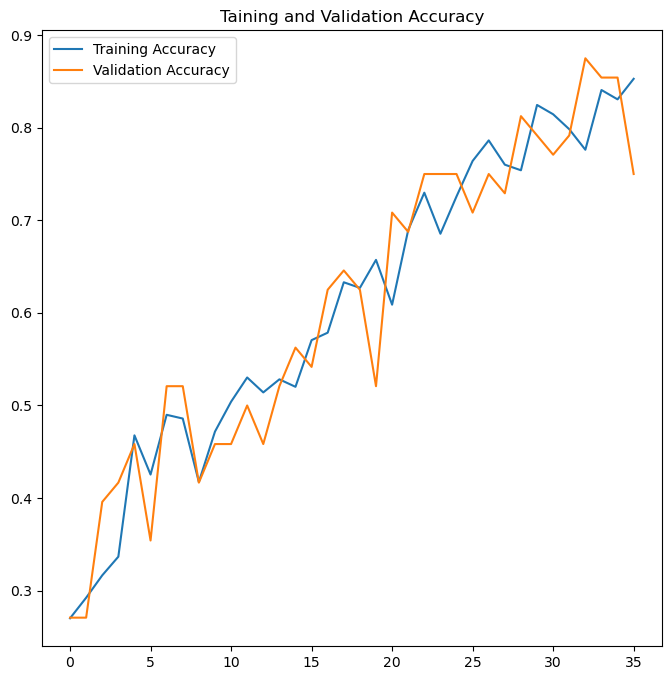

In [23]:
plt.figure(figsize=(8,8))

plt.plot(range(36),acc,label='Training Accuracy')
plt.plot(range(36),val_acc,label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Taining and Validation Accuracy')

In [24]:
scores=model.evaluate(test_ds)

3/3 [==============================] - 9s 85ms/step - loss: 0.2980 - accuracy: 0.9062


# Make predictions and inferences on Sample Images:

 The First image is:
The actual label is: No disease
1/1 [==============================] - 0s 63ms/step
The predicted class is: No disease


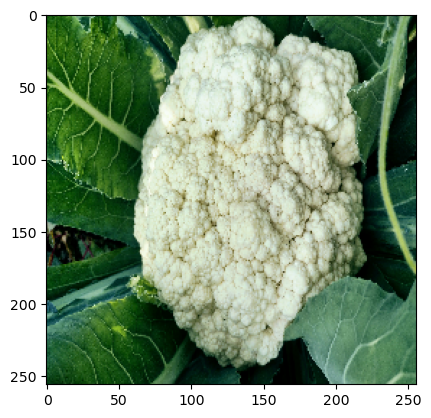

In [27]:
import numpy as np

for image_batch,label_batch in dataset.take(1):
    print(' The First image is:')
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    print('The actual label is:',class_names[label_batch[0]])
    
    batch_predict=model.predict(image_batch)
    print('The predicted class is:',class_names[np.argmax(batch_predict[0])])

In [28]:
def predict_image(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    imag_array=tf.expand_dims(img_array,0) # create a batch
    
    prediction=model.predict(img_array)
    
    predicted_class=class_names[np.argmax(prediction[0])]
    confidence=round(100*(np.max(prediction[0])),2)
    return predicted_class, confidence

ValueError: in user code:

    File "/Users/sivapratheek/anaconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "/Users/sivapratheek/anaconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/sivapratheek/anaconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/sivapratheek/anaconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py", line 2283, in predict_step
        return self(x, training=False)
    File "/Users/sivapratheek/anaconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer 'sequential_2' (type Sequential).
    
    Cannot iterate over a shape with unknown rank.
    
    Call arguments received by layer 'sequential_2' (type Sequential):
      • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
      • training=False
      • mask=None


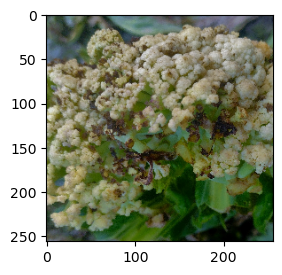

In [31]:
plt.figure(figsize=(10,10))

for images, labels in dataset.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predict_class, confidence=predict_image(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        break
        plt.title(f'Actual: {actual_class},\n Predicted Class: {predict_class}, \n Confidence:{confidence}')
        
        
        plt.axis('off')

# Saving the model:

In [ ]:
import os
model_version=max([int(i) for i in os.listdir('../models_potato')+[0]])+1
model.save(f'../models_potato/{model_version}')